Mai 2022.

Si Fig. 5.

Adapted from the notebook for monkey A.

Trained with mante_fit_lowrank.py

In [12]:
from scipy.io import loadmat
from scipy.stats import kurtosis
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
from low_rank_rnns import plotting as plot, stats, helpers, mante, clustering
from low_rank_rnns import data_loader_mante as dlm
from low_rank_rnns.modules import *
from sklearn.linear_model import LinearRegression

In [13]:
plot.setup_matplotlib()
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 22

# Preparing the dataset

In [14]:
%%time
bin_width = 5
smoothing_width = 50

dataset = dlm.ManteDataset(monkey='F', bin_width=bin_width, smoothing_width=smoothing_width, cavg=True)

Loading data for monkey F
loaded 640 units, binned at 5.0ms
Averaging over 144 conditions
CPU times: user 33.7 s, sys: 7.36 s, total: 41.1 s
Wall time: 1min 2s


In [15]:
# Selecting neurons that have at least one trial for each correct condition
correct_trials = dataset.conditions.correct == 1
good_neurons = ~np.any(dataset.ntrials[correct_trials] == 0, axis=0)
print(good_neurons.sum())
neurons_map_orig = np.where(good_neurons)[0]

# X_all is the data averaged tensor for "valid neurons", X is the same tensor with only non-error trials
X_all = dataset.data_avg[:, :, good_neurons]
X = dataset.data_avg[correct_trials][:, :, good_neurons]
print(X.shape)
# np.save('../data/X_monkeyF.npy', X)
# dataset.conditions.to_csv('../data/conditions_monkeyF.csv')

574
(72, 150, 574)


In [16]:
choice = dataset.conditions[correct_trials]['choice']
context = dataset.conditions[correct_trials]['context']
direction = dataset.conditions[correct_trials]['stim_dir_lvl']
color = dataset.conditions[correct_trials]['stim_col_lvl']

In [17]:
nconds, ntime, n_neurons = X.shape

In [18]:
hidden_neurons = 0
size = n_neurons + hidden_neurons

# Denoising - regression

(10800, 574)
0.6377151953185474


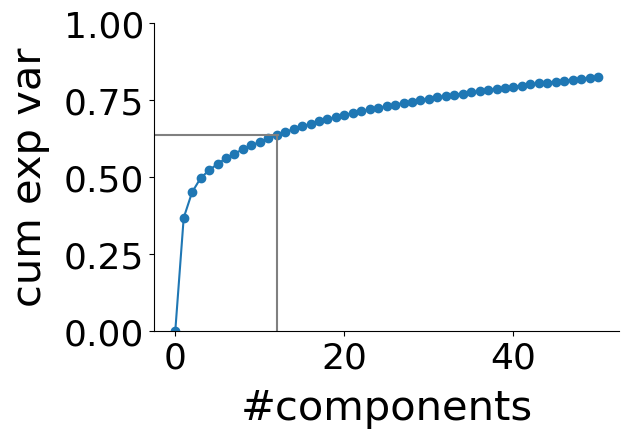

In [19]:
# Denoise data
X_flat = helpers.flatten_trajectory(X)
X_mean = np.mean(X_flat, axis=0)
X_flat = (X_flat - X_mean)
pca_std = plot.pca_cumvar(X_flat, n_components=50)
denoise_mat = pca_std.components_[:12]
X_den = X_flat @ denoise_mat.T @ denoise_mat
X_den_unflat = helpers.unflatten_trajectory(X_den, nconds)
X_den_tot = X_den_unflat + X_mean

plt.xlabel('#components')
plt.ylabel('cum exp var')
plt.axvline(12, 0, pca_std.explained_variance_ratio_[:12].sum(), c='gray')
plt.axhline(pca_std.explained_variance_ratio_[:12].sum(), 0, 16/60, c='gray')
print(pca_std.explained_variance_ratio_[:12].sum())

# Prepare training set, initial states for trajectories...
istates_all = torch.from_numpy(np.concatenate([X_den_tot[:, 0, :], np.zeros((nconds, hidden_neurons))], axis=1)).to(dtype=torch.float32)
istates_inv = torch.from_numpy(helpers.inverse_softplus(istates_all.numpy()))

In [20]:
# Perform linear regression, define centered dataset
conditions_regressors = dataset.conditions[correct_trials][['choice', 'stim_dir', 'stim_col', 'context']].to_numpy()
X_den_percond = X_den_unflat.reshape((nconds, -1))
print(conditions_regressors.shape)
print(X_den_percond.shape)

# Linear regression
linmodel = LinearRegression(fit_intercept=True)
linmodel = linmodel.fit(conditions_regressors, X_den_percond)
betas = linmodel.coef_.T.reshape((4, ntime, -1))
intercepts = linmodel.intercept_.T.reshape((ntime, -1))
betas = np.concatenate([betas, intercepts[np.newaxis, :, :]], axis=0)
print(betas.shape)

# Denoise betas
betas = betas @ denoise_mat.T @ denoise_mat

# Data without the time component
X_cent = X_den_unflat - betas[-1]
# np.save('../data/X_cent_monkeyF.npy', X_cent)

(72, 4)
(72, 86100)
(5, 150, 574)


(574, 4)


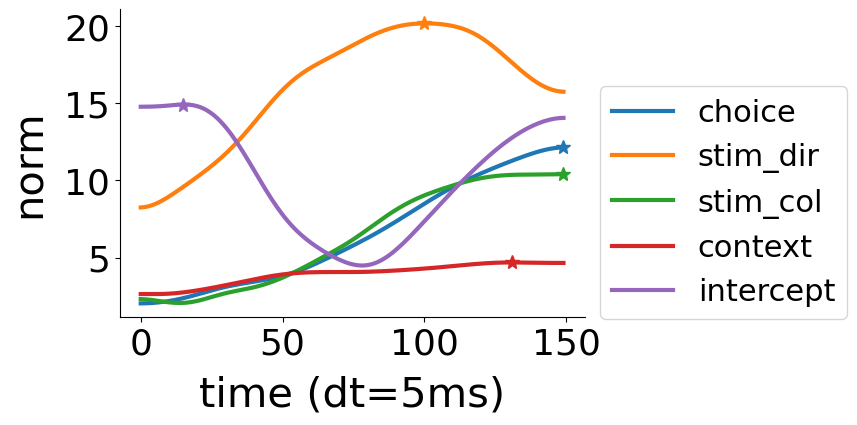

In [21]:
betas_norms = np.array([[np.linalg.norm(betas[i, t]) for t in range(ntime)] for i in range(5)])
labels = ['choice', 'stim_dir', 'stim_col', 'context', 'intercept']

tmaxes = []
for i in range(5):
    p,  = plt.plot(betas_norms[i], label=labels[i], lw=3)
    tmax = np.argmax(betas_norms[i])
    tmaxes.append(tmax)
    plt.plot(tmax, betas_norms[i, tmax], marker='*', c=p.get_color(), markersize=10)
plt.legend(bbox_to_anchor=(1, .8))
plt.ylabel('norm')
plt.xlabel('time (dt=5ms)')

# Choose timepoints for the axes, orthogonalize
beta_choice = betas[0, tmaxes[0]]
beta_motion = betas[1, tmaxes[1]]
beta_color = betas[2, tmaxes[2]]
beta_context = betas[3, tmaxes[3]]
Bmat = np.vstack([beta_choice, beta_motion, beta_color, beta_context]).T
print(Bmat.shape)
BmatQ, _ = np.linalg.qr(Bmat)
beta_choice = BmatQ[:, 0]
beta_motion = BmatQ[:, 1]
beta_color = BmatQ[:, 2]
beta_context = BmatQ[:, 3]

# Preparing inputs

In [22]:
mante.fixation_duration = 0
mante.ctx_only_pre_duration = 350
mante.stimulus_duration = 650
mante.delay_duration = 95
mante.decision_duration = 5
mante.deltaT = bin_width
mante.setup()

# Input scale has a huge effect : set at 1 for the latest trainings
mante.SCALE = 1
mante.SCALE_CTX = 1


correct_trials = dataset.conditions.correct == 1
inputs, targets_task, mask_task = mante.generate_mante_data_from_conditions(dataset.conditions[correct_trials]['stim_dir'].values,
                                                         dataset.conditions[correct_trials]['stim_col'].values,
                                                         dataset.conditions[correct_trials]['context'].values)
coherences = np.unique(dataset.conditions[correct_trials]['stim_dir'].to_numpy())
coherences

array([-0.53734375, -0.194125  , -0.07175   ,  0.07175   ,  0.194125  ,
        0.53734375])

In [23]:
hidden_neurons = 0
size = n_neurons + hidden_neurons

# Initial conditions (72 of them)
# istates = np.concatenate([X_cent[:, 0, :], np.zeros((nconds, hidden_neurons))], axis=1)
# istates = torch.from_numpy(istates).to(dtype=torch.float32)


# Initial conditions (2, one for each context)
istates = np.zeros((nconds, n_neurons))
istates[context == -1] = X_cent[context==-1, 0, :].mean(axis=0)
istates[context == 1] = X_cent[context==1, 0, :].mean(axis=0)
istates = torch.from_numpy(istates).to(dtype=torch.float32)

# Full-rank net

In [25]:
net_fr = FullRankRNN(4, size, n_neurons, 0, 0.2, output_non_linearity=(lambda x: x))
net_fr.load_state_dict(torch.load('../models/mante_monkeyF_subspace_5.pt'))

<All keys matched successfully>

In [26]:
_, traj = net_fr(inputs, initial_states=istates, return_dynamics=True)
traj = traj.detach().numpy()[:, mante.ctx_only_pre_duration_discrete+1:, :n_neurons]

In [27]:
r2_global_fr = stats.r2_score(X_cent.ravel(), traj.ravel())
print(f'R2 global: {r2_global_fr}')
print(f'R2 per neuron mean: {stats.r2_idneurons(X_cent, traj)}')

R2 global: 0.6797363619806012
R2 per neuron mean: -3.6917128429718598


In [28]:
r2s = np.array(stats.r2_idneurons(X_cent, traj, return_all=True))
print(f'R2 per neuron median: {np.median(r2s)}')

R2 per neuron median: 0.5013585146410255


In [29]:
decisions = np.sign((traj @ beta_choice)[:, -1])
acc_fr = (choice.values == -decisions).sum() / 72
print(acc_fr)

0.9861111111111112


Text(0, 0.5, 'R2')

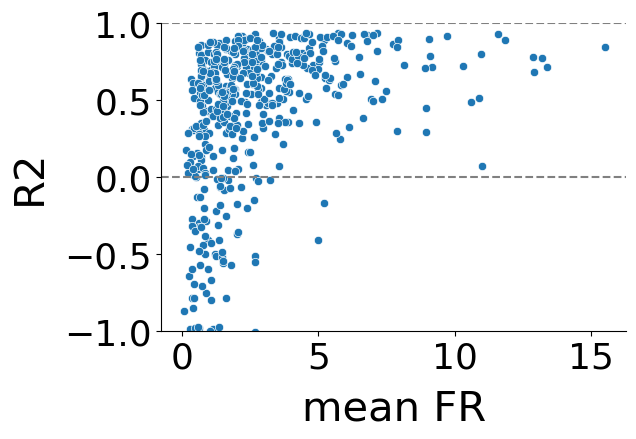

In [31]:
sns.scatterplot(x=X_mean, y=r2s)
plt.ylim(-1, 1)
plt.axhline(0, c='gray', ls='--')
plt.axhline(1, c='gray', ls='--')
plt.xlabel('mean FR')
plt.ylabel('R2')

In [32]:
# Training a linear readout for the full-rank fitted RNN
net_fr_behav = FullRankRNN(4, size, 1, 0, 0.2, wi_init=net_fr.wi_full, wrec_init=net_fr.wrec,
                           wo_init=torch.from_numpy(beta_choice.reshape((-1, 1))) / size, train_wi=False, 
                           train_si=False, train_wrec=False, train_wo=True)
train(net_fr_behav, inputs, targets_task, mask_task, 20, lr=1e-3, keep_best=True)
loss, acc = mante.test_mante(net_fr_behav, inputs, targets_task, mask_task)
print(acc)

Training...
initial loss: 1.027
epoch 0:  loss=0.903  (took 0.29 s) *
epoch 1:  loss=0.448  (took 0.26 s) *
epoch 2:  loss=0.190  (took 0.25 s) *
epoch 3:  loss=0.059  (took 0.25 s) *
epoch 4:  loss=0.066  (took 0.27 s)
epoch 5:  loss=0.077  (took 0.27 s)
epoch 6:  loss=0.127  (took 0.27 s)
epoch 7:  loss=0.143  (took 0.27 s)
epoch 8:  loss=0.132  (took 0.28 s)
epoch 9:  loss=0.089  (took 0.27 s)
epoch 10:  loss=0.052  (took 0.27 s) *
epoch 11:  loss=0.039  (took 0.26 s) *
epoch 12:  loss=0.044  (took 0.29 s)
epoch 13:  loss=0.050  (took 0.30 s)
epoch 14:  loss=0.046  (took 0.31 s)
epoch 15:  loss=0.045  (took 0.32 s)
epoch 16:  loss=0.047  (took 0.30 s)
epoch 17:  loss=0.036  (took 0.31 s) *
epoch 18:  loss=0.025  (took 0.33 s) *
epoch 19:  loss=0.044  (took 0.33 s)
1.0


In [35]:
# Poorly fitted neurons
idx_bad = np.where(r2s < 0)[0]
print(len(idx_bad))

161


In [36]:
# Can the network perform the task without all the poorly fitted neurons?
neurons_map_fr = np.setdiff1d(np.arange(size), idx_bad)
print(size - len(idx_bad))
net_fr_behav = FullRankRNN(4, size - len(idx_bad), 1, 0, 0.2,
                     wi_init=net_fr.wi_full[:, neurons_map_fr], wrec_init=net_fr.wrec[neurons_map_fr][:, neurons_map_fr],
                     wo_init=torch.from_numpy(beta_choice[neurons_map_fr].reshape((-1, 1))) / size,
                     train_wi=False, train_si=False, train_wrec=False, train_wo=True)

outp, traj = net_fr_behav(inputs, return_dynamics=True)
traj = traj.detach().numpy()[:, mante.ctx_only_pre_duration_discrete+1:, :][:, :, :n_neurons]
r2_global_fr2 = stats.r2_score(X_cent[:, :, neurons_map_fr].ravel(), traj.ravel())
print(f'R2 global: {r2_global_fr}')
r2s = np.array(stats.r2_idneurons(X_cent[:, :, neurons_map_fr], traj, return_all=True))
print(f'R2 per neuron median: {np.median(r2s)}')
r2_median_fr2 = np.median(r2s)
print(f'R2 per neuron mean: {np.mean(r2s)}')
train(net_fr_behav, inputs, targets_task, mask_task, 50, lr=1e-3, keep_best=True)
loss, acc = mante.test_mante(net_fr_behav, inputs, targets_task, mask_task)
print(acc)

413
R2 global: 0.6797363619806012
R2 per neuron median: -0.9121353082189785
R2 per neuron mean: -1.2151026065726864
Training...
initial loss: 1.000
epoch 0:  loss=0.990  (took 0.19 s) *
epoch 1:  loss=0.937  (took 0.19 s) *
epoch 2:  loss=0.966  (took 0.19 s)
epoch 3:  loss=0.875  (took 0.17 s) *
epoch 4:  loss=0.848  (took 0.17 s) *
epoch 5:  loss=0.837  (took 0.17 s) *
epoch 6:  loss=0.745  (took 0.18 s) *
epoch 7:  loss=0.871  (took 0.19 s)
epoch 8:  loss=0.797  (took 0.29 s)
epoch 9:  loss=0.814  (took 0.17 s)
epoch 10:  loss=0.793  (took 0.18 s)
epoch 11:  loss=0.729  (took 0.19 s) *
epoch 12:  loss=0.685  (took 0.19 s) *
epoch 13:  loss=0.731  (took 0.20 s)
epoch 14:  loss=0.777  (took 0.19 s)
epoch 15:  loss=0.754  (took 0.19 s)
epoch 16:  loss=0.720  (took 0.23 s)
epoch 17:  loss=0.854  (took 0.22 s)
epoch 18:  loss=0.688  (took 0.22 s)
epoch 19:  loss=0.734  (took 0.25 s)
epoch 20:  loss=0.661  (took 0.22 s) *
epoch 21:  loss=0.693  (took 0.22 s)
epoch 22:  loss=0.605  (took 0

In conclusion, no readout has been found so that the network without the poorly fitted networks performs the task.

# Low-rank networks

In [37]:
r2s_glob = []
r2s_medians = []
accs = []

ranks = list(range(1, 6))
for rank in ranks:
    net = LowRankRNN(4, size, n_neurons, 0, 0.2, rank=rank, output_non_linearity=(lambda x: x))
    net.load_state_dict(torch.load(f'../models/mante_monkeyF_subspace_rank{rank}_5.pt'))
    _, traj = net(inputs, initial_states=istates, return_dynamics=True)
    # traj = net.non_linearity(traj)
    traj = traj.detach().numpy()[:, mante.ctx_only_pre_duration_discrete+1:][:, :, :n_neurons]
    
    r2s_glob.append(stats.r2_score(X_cent.ravel(), traj.ravel()))
    print(f'Rank {rank}, test R2 global: {r2s_glob[-1]}')
    
    r2s_all = stats.r2_idneurons(X_cent, traj, return_all=True)
    print(f'Rank {rank}, test R2 per neuron mean: {np.mean(r2s_all)}')
    r2s_medians.append(np.median(r2s_all))
    print(f'Rank {rank}, test R2 per neuron median: {r2s_medians[-1]}')
    
    decisions = np.sign((traj @ beta_choice)[:, -1])
    acc = (choice.values == -decisions).sum() / 72
    print(f'Rank {rank}, accuracy: {acc:.2f}')
    accs.append(acc)

Rank 1, test R2 global: 0.5704185891488796
Rank 1, test R2 per neuron mean: 0.21732184516337577
Rank 1, test R2 per neuron median: 0.5160716273747314
Rank 1, accuracy: 0.99
Rank 2, test R2 global: 0.5943832440331374
Rank 2, test R2 per neuron mean: -0.833387852377327
Rank 2, test R2 per neuron median: 0.5273519964370521
Rank 2, accuracy: 0.96
Rank 3, test R2 global: 0.5986281107875309
Rank 3, test R2 per neuron mean: 0.4029827305067507
Rank 3, test R2 per neuron median: 0.5377459415215101
Rank 3, accuracy: 0.94
Rank 4, test R2 global: 0.59917250224182
Rank 4, test R2 per neuron mean: 0.4417195810142905
Rank 4, test R2 per neuron median: 0.5224145590999529
Rank 4, accuracy: 0.99
Rank 5, test R2 global: 0.5898135721213154
Rank 5, test R2 per neuron mean: 0.4186991936954809
Rank 5, test R2 per neuron median: 0.5247713394670094
Rank 5, accuracy: 1.00


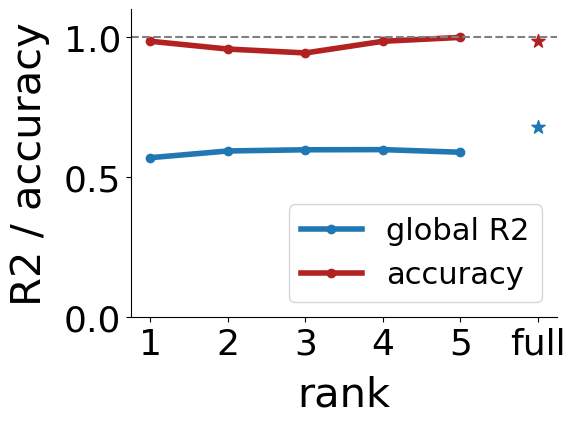

In [38]:
plt.figure(figsize=(5.5, 4))
# plt.plot(ranks, r2s_glob, marker='o', label='global', c='tab:blue', lw=3, markersize=9)
plt.plot(ranks, r2s_glob, marker='o', c='tab:blue', label='global R2', lw=4)
plt.plot(ranks, accs, marker='o', c='firebrick', label='accuracy', lw=4)
plt.scatter([6], [r2_global_fr], color='tab:blue', marker='*', s=100)
plt.scatter([6], [acc_fr], color='firebrick', marker='*', s=100)
plt.ylim(0, 1.1)
plt.yticks([0, .5, 1])
plt.xticks([1, 2, 3, 4, 5, 6])
plt.gca().set_xticklabels([1, 2, 3, 4, 5, 'full'])
plt.legend(loc='lower right')
plt.xlabel('rank')
plt.ylabel('R2 / accuracy')
plt.axhline(1, ls='--', c='gray')
# plt.savefig('../figures/neurips/monkeyF_r2acc.pdf', bbox_inches='tight')

# Looking at rank 1 net

In [39]:
rank = 1
net = LowRankRNN(4, size, n_neurons, 0, 0.2, rank=rank, output_non_linearity=(lambda x: x))
net.load_state_dict(torch.load(f'../models/mante_monkeyF_subspace_rank{rank}_5.pt'))

In [40]:
_, traj = net(inputs, initial_states=istates, return_dynamics=True)
traj = traj.detach().numpy()[:, :, :n_neurons]

In [41]:
r2s_all = stats.r2_idneurons(X_cent, traj[:, mante.ctx_only_pre_duration_discrete+1:], return_all=True)

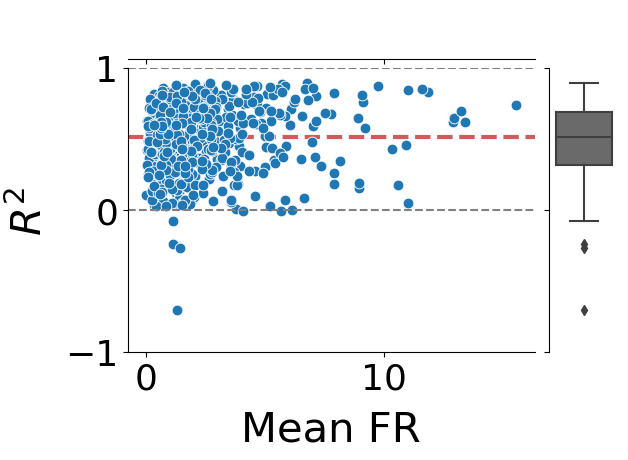

In [47]:
g = sns.JointGrid()
g.fig.set_figwidth(6)
g.fig.set_figheight(4)
sns.scatterplot(x=X_mean, y=r2s_all, s=60, ax=g.ax_joint, color='tab:blue')
sns.boxplot(y=r2s_all, ax=g.ax_marg_y, saturation=0)
# sns.kdeplot(x=X_mean, ax=g.ax_marg_x)
g.ax_joint.set_xlabel('Mean FR')
g.ax_joint.set_ylabel('$R^2$')
g.ax_joint.axhline(0, c='gray', ls='--')
g.ax_joint.axhline(1, c='gray', ls='--')
g.ax_joint.axhline(np.median(r2s_all), c='indianred', ls='--', lw=3, zorder=0)
plt.ylim(-1, 1)
plt.savefig('../figures/neurips/monkeyF_r2s.pdf', bbox_inches='tight')

In [49]:
dx_bad = np.where(r2s_all < 0)[0]
print(len(idx_bad))  # Much much less poorly fitted neurons ! :D

18


In [50]:
net_behav = LowRankRNN(4, size, 1, 0, 0.2, rank=1, output_non_linearity=(lambda x: x), 
                       wi_init=net.wi_full, m_init=net.m, n_init=net.n, 
                       wo_init=torch.from_numpy(-beta_choice.reshape((-1, 1))),
                       train_wi=False, train_wrec=False, train_si=False, train_wo=True)
train(net_behav, inputs, targets_task, mask_task, 40, lr=5e-2, keep_best=True)

Training...
initial loss: 0.964
epoch 0:  loss=0.950  (took 0.19 s) *
epoch 1:  loss=0.903  (took 0.19 s) *
epoch 2:  loss=0.842  (took 0.19 s) *
epoch 3:  loss=0.797  (took 0.20 s) *
epoch 4:  loss=0.760  (took 0.20 s) *
epoch 5:  loss=0.732  (took 0.19 s) *
epoch 6:  loss=0.668  (took 0.18 s) *
epoch 7:  loss=0.640  (took 0.18 s) *
epoch 8:  loss=0.579  (took 0.18 s) *
epoch 9:  loss=0.563  (took 0.19 s) *
epoch 10:  loss=0.533  (took 0.19 s) *
epoch 11:  loss=0.473  (took 0.19 s) *
epoch 12:  loss=0.448  (took 0.19 s) *
epoch 13:  loss=0.416  (took 0.18 s) *
epoch 14:  loss=0.383  (took 0.18 s) *
epoch 15:  loss=0.304  (took 0.19 s) *
epoch 16:  loss=0.373  (took 0.19 s)
epoch 17:  loss=0.274  (took 0.18 s) *
epoch 18:  loss=0.327  (took 0.19 s)
epoch 19:  loss=0.306  (took 0.19 s)
epoch 20:  loss=0.202  (took 0.18 s) *
epoch 21:  loss=0.276  (took 0.19 s)
epoch 22:  loss=0.241  (took 0.18 s)
epoch 23:  loss=0.190  (took 0.20 s) *
epoch 24:  loss=0.258  (took 0.19 s)
epoch 25:  loss

0.15623576939105988 0.9861111044883728


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

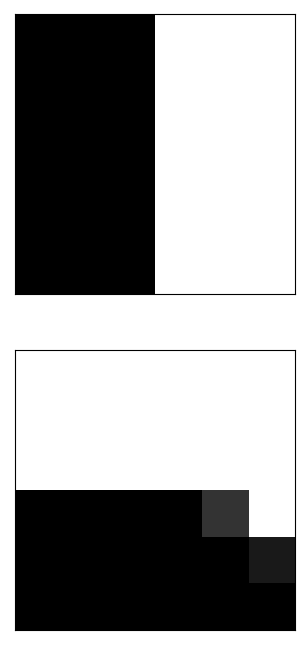

In [51]:
loss, acc = mante.test_mante(net_behav, inputs, targets_task, mask_task)
print(loss, acc)
mante.psychometric_matrices(net_behav, coherences=coherences)

In [53]:
# So what about the network without the poorly fitted neurons?
net_tmp = net_behav.clone()
with torch.no_grad():
    net_tmp.wi[:, idx_bad] = 0
    net_tmp.m[idx_bad] = 0
    net_tmp.n[idx_bad] = 0
loss, acc = mante.test_mante(net_tmp, inputs, targets_task, mask_task)
print(loss, acc)
train(net_tmp, inputs, targets_task, mask_task, 50, lr=5e-2, keep_best=True)

0.6462436318397522 0.7777777910232544
Training...
initial loss: 0.646
epoch 0:  loss=0.597  (took 0.19 s) *
epoch 1:  loss=0.610  (took 0.19 s)
epoch 2:  loss=0.613  (took 0.18 s)
epoch 3:  loss=0.670  (took 0.19 s)
epoch 4:  loss=0.645  (took 0.20 s)
epoch 5:  loss=0.586  (took 0.19 s) *
epoch 6:  loss=0.517  (took 0.18 s) *
epoch 7:  loss=0.594  (took 0.19 s)
epoch 8:  loss=0.585  (took 0.19 s)
epoch 9:  loss=0.639  (took 0.19 s)
epoch 10:  loss=0.684  (took 0.19 s)
epoch 11:  loss=0.635  (took 0.19 s)
epoch 12:  loss=0.555  (took 0.19 s)
epoch 13:  loss=0.575  (took 0.19 s)
epoch 14:  loss=0.620  (took 0.20 s)
epoch 15:  loss=0.574  (took 0.20 s)
epoch 16:  loss=0.579  (took 0.19 s)
epoch 17:  loss=0.562  (took 0.20 s)
epoch 18:  loss=0.586  (took 0.20 s)
epoch 19:  loss=0.544  (took 0.20 s)
epoch 20:  loss=0.541  (took 0.22 s)
epoch 21:  loss=0.640  (took 0.22 s)
epoch 22:  loss=0.503  (took 0.22 s) *
epoch 23:  loss=0.445  (took 0.23 s) *
epoch 24:  loss=0.602  (took 0.23 s)
epoch

0.5461897850036621 0.8194444179534912


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

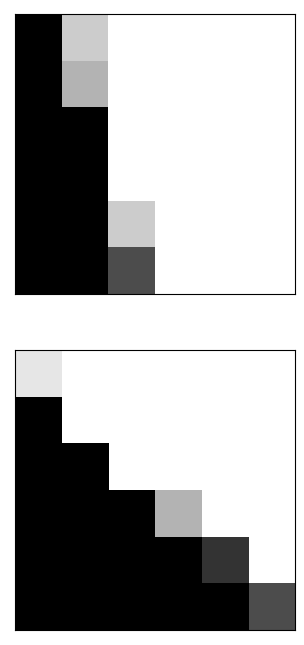

In [55]:
loss, acc = mante.test_mante(net_tmp, inputs, targets_task, mask_task)
print(loss, acc)
mante.psychometric_matrices(net_tmp, coherences=coherences)

The network without the poorly fitted neurons, even though there's only 18 of them, is still not really there.

## Single neurons

In [56]:
conditions_sample = [((direction == 0) & (color == 5) & (context == 1)),
                     ((direction == 5) & (color == 0) & (context == 1)),
                     ((direction == 5) & (color == 0) & (context == -1)),
                     ((direction == 0) & (color == 5) & (context == -1))]
cmap1 = matplotlib.cm.get_cmap('bwr')
cmap2 = matplotlib.cm.get_cmap('PiYG')
colors = ['royalblue', 'seagreen', 'firebrick', 'darkorange']

-49.14543543182192


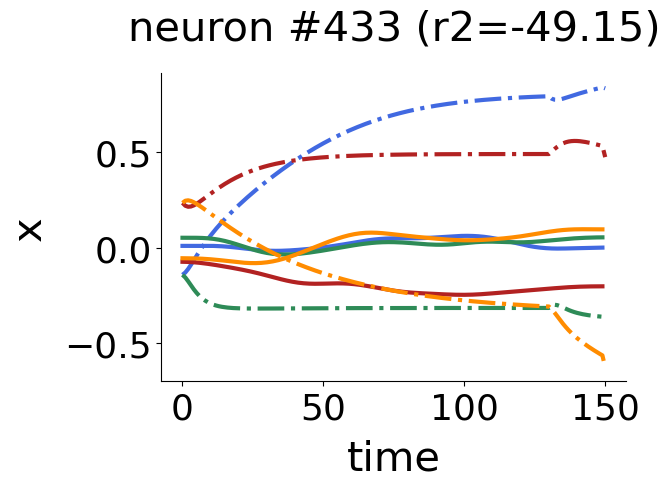

-30.311821438346136


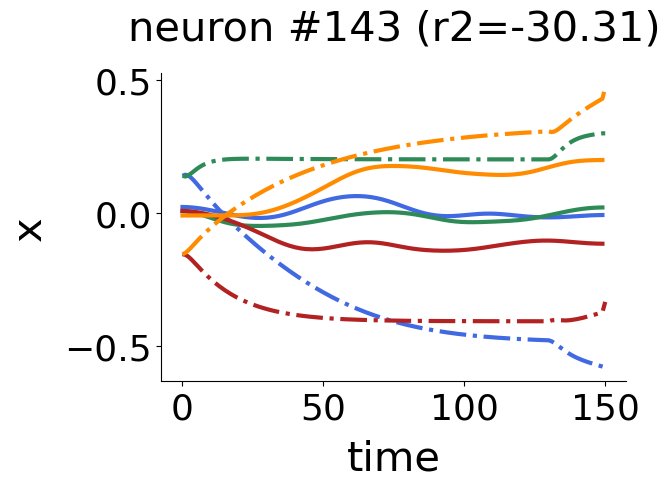

-27.51828453162201


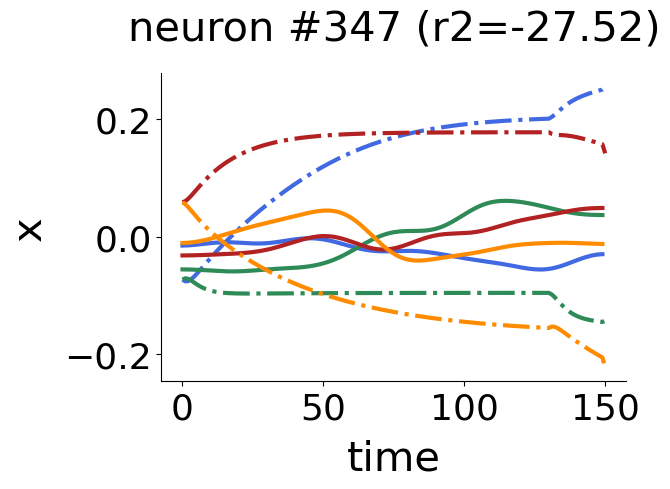

-12.064120368361854


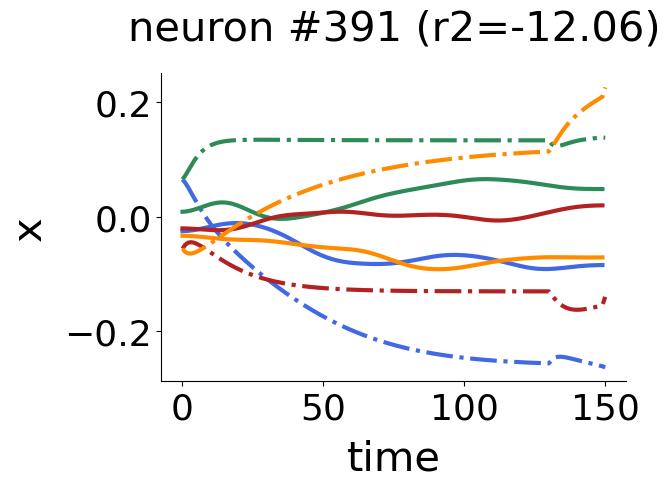

-9.282137716378573


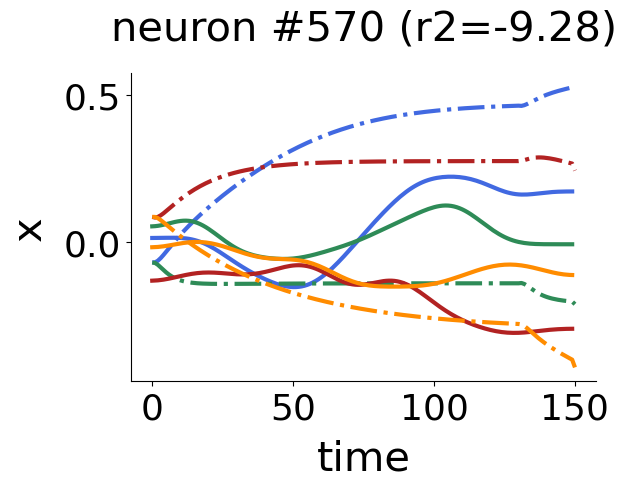

-9.167509382034178


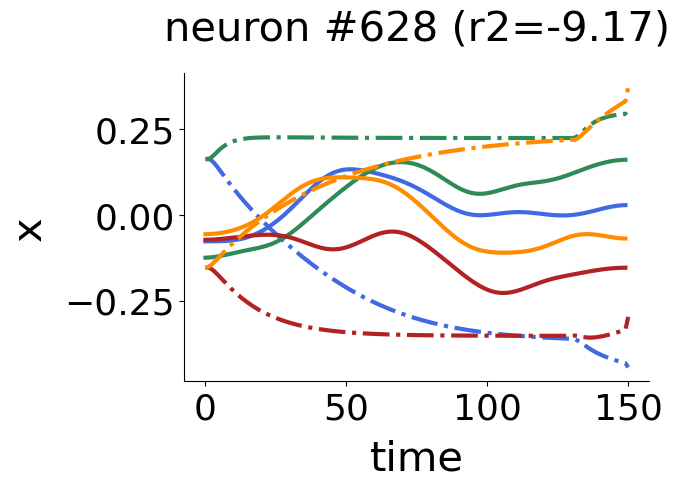

-7.160360421521808


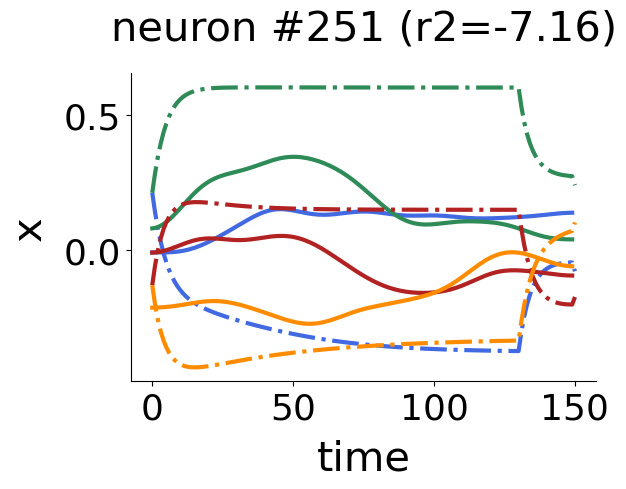

-4.0300096106344965


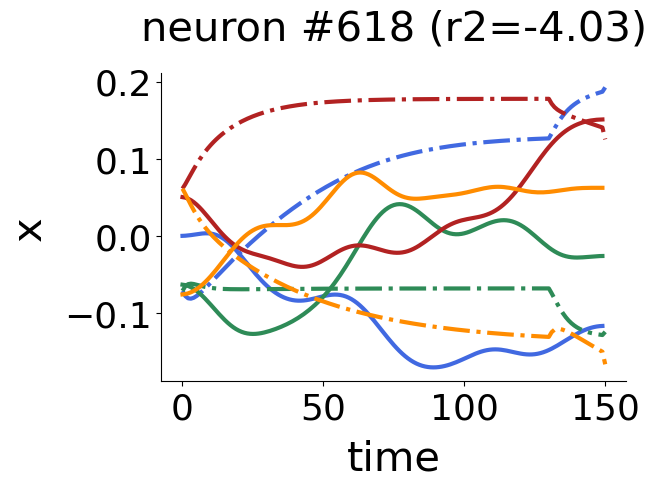

-3.873486199260123


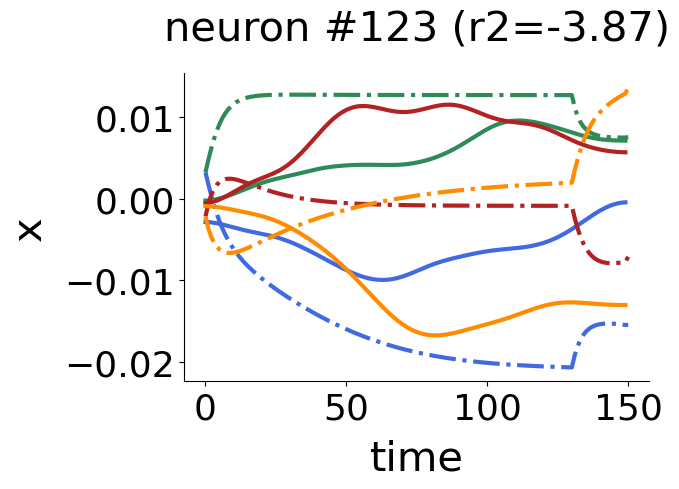

-3.701901525131867


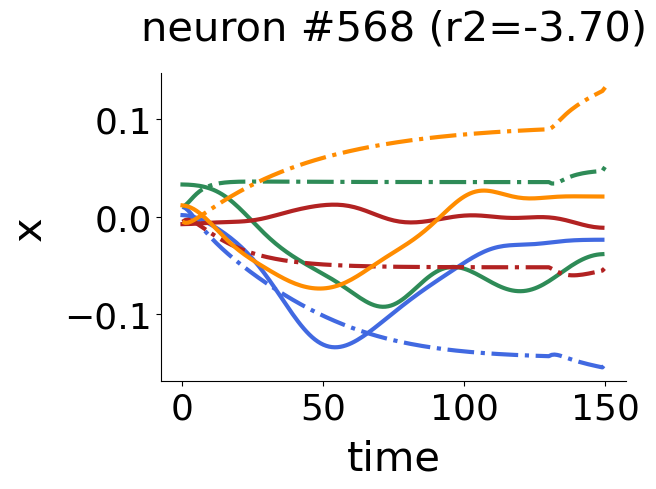

-1.2090203846304086


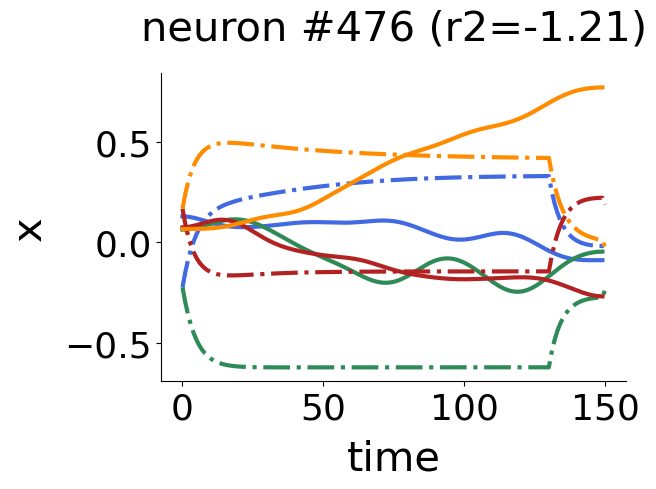

-1.0461554672444477


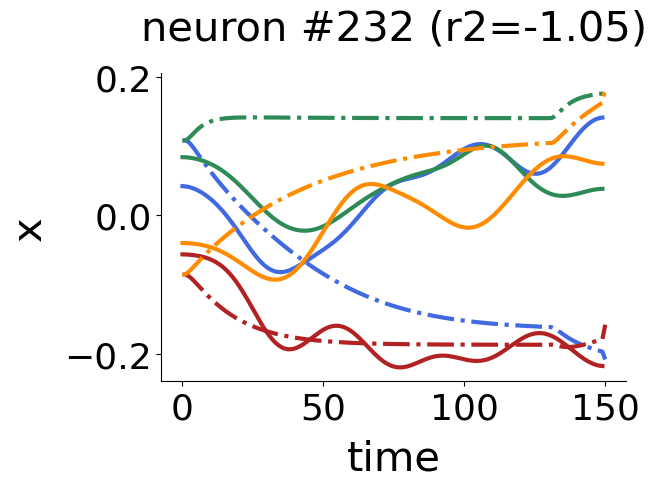

-0.7037036613722258


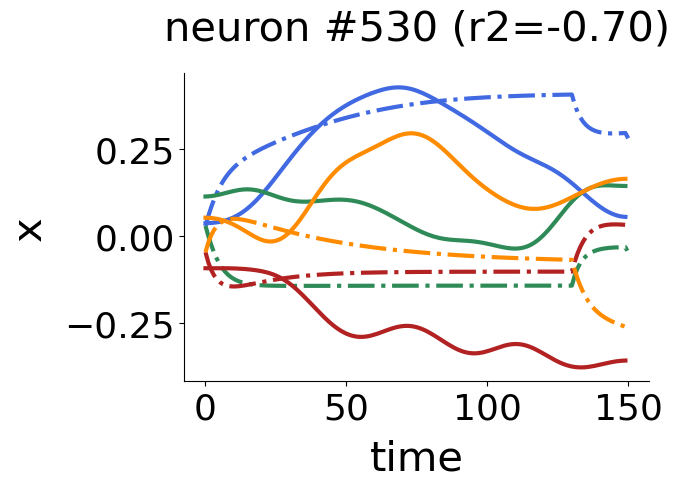

-0.2662072583595356


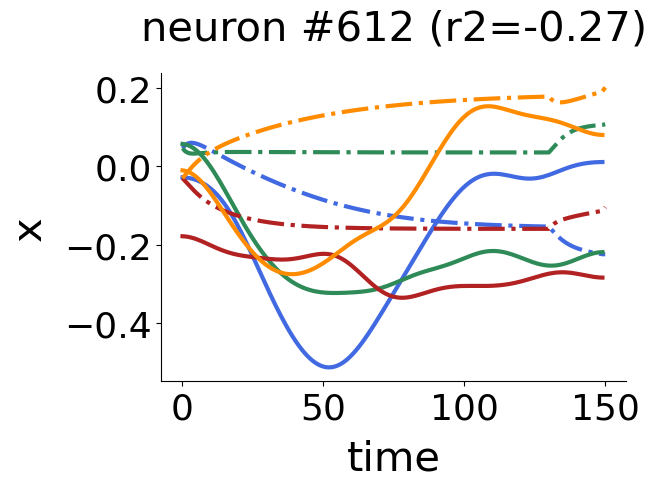

-0.23774479730585774


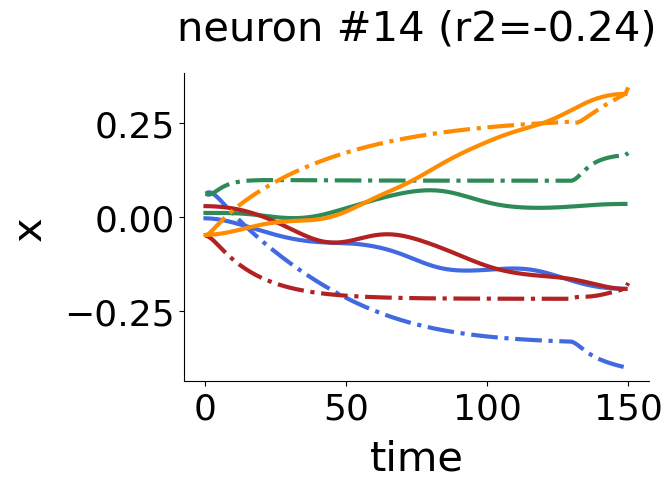

-0.07395063755508557


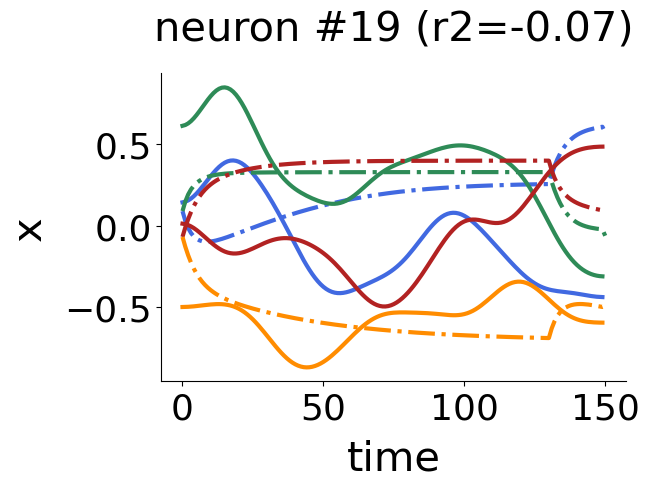

-0.005991145259935715


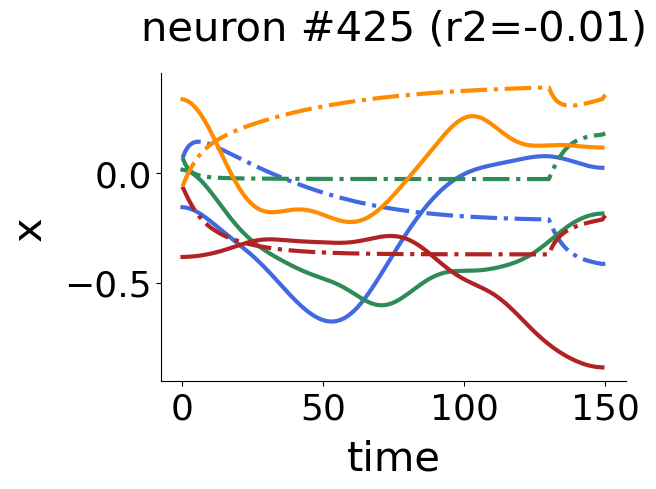

-0.0047176905190084995


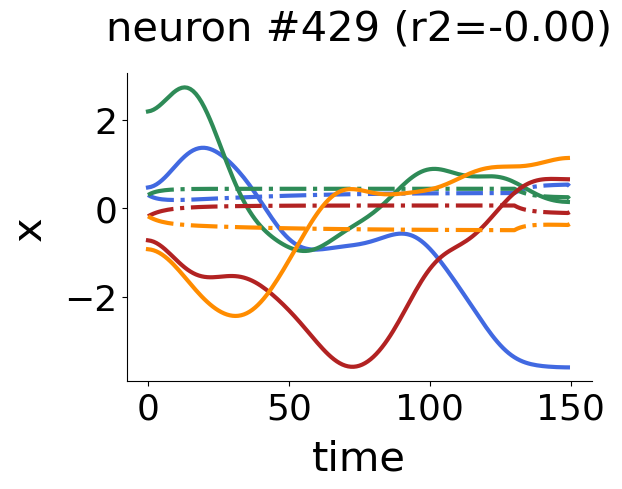

In [58]:
# conditions_rsample = random.sample(range(nconds), 4)
for i in np.argsort(r2s_all)[:18]:
    print(r2s_all[i])
    for c, k in enumerate(conditions_sample):
        pl, = plt.plot(X_cent[k, :, i].squeeze(), c=colors[c], lw=3)
        plt.plot(traj[k, mante.ctx_only_pre_duration_discrete:, i].squeeze(), ls='-.', c=pl.get_color(), lw=3)
    plt.title(f'neuron #{neurons_map_orig[i]} (r2={r2s_all[i]:.2f})')
    plt.xlabel('time')
    plt.ylabel('x')
    plt.savefig(f'../figures/neurips/monkeyF_neuron{neurons_map_orig[i]}.pdf', bbox_inches='tight')
    plt.show()
    

0.896626997267502


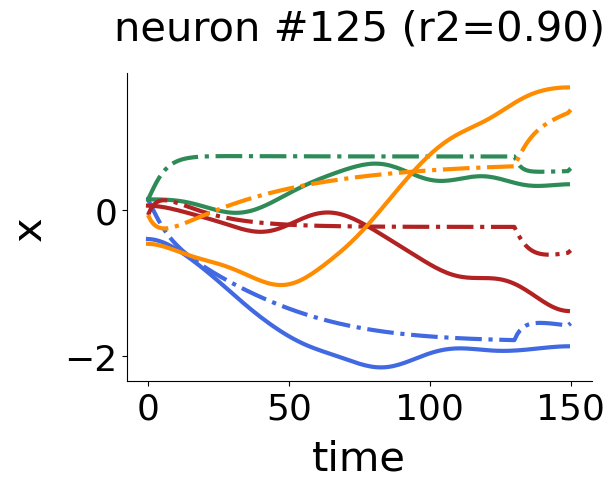

0.8941005547706347


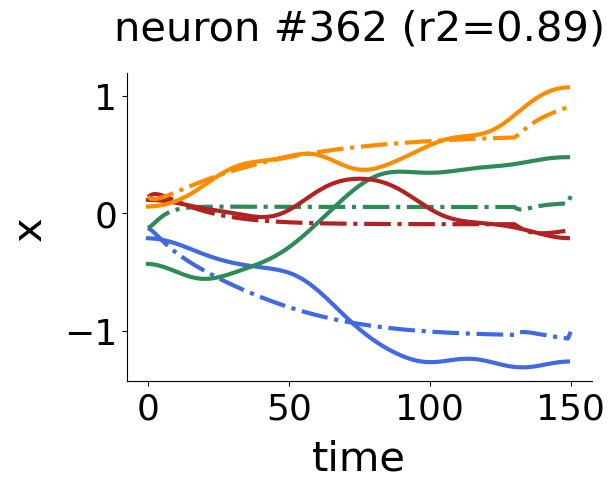

0.8918426611829199


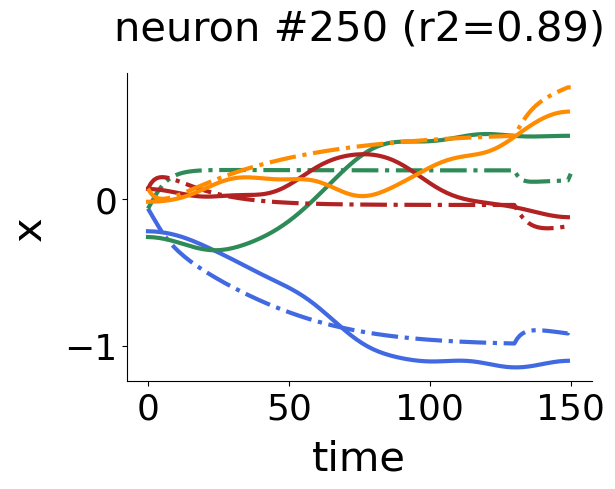

0.8905923238858843


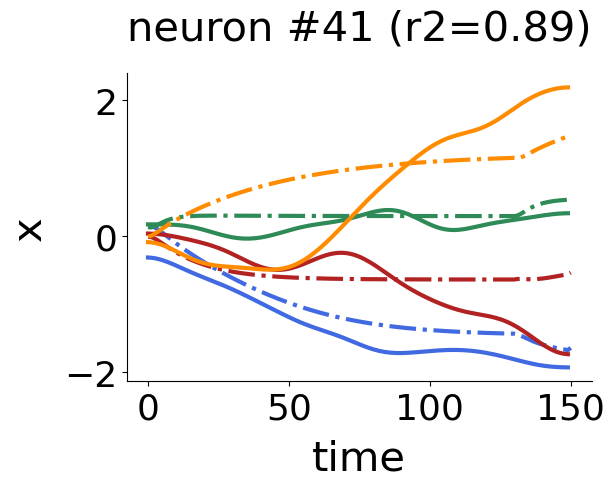

0.885494034053444


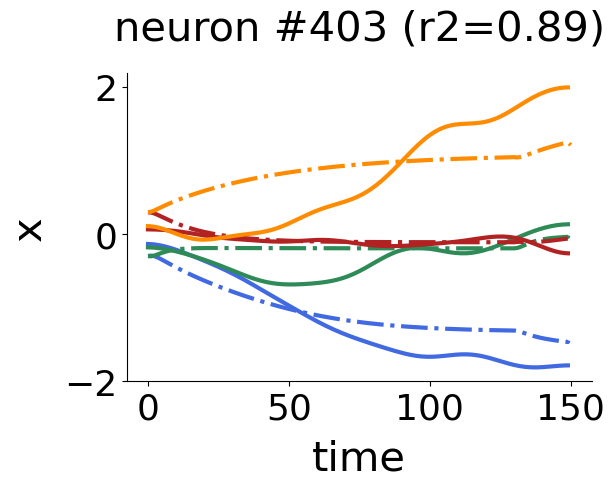

0.8810246881998813


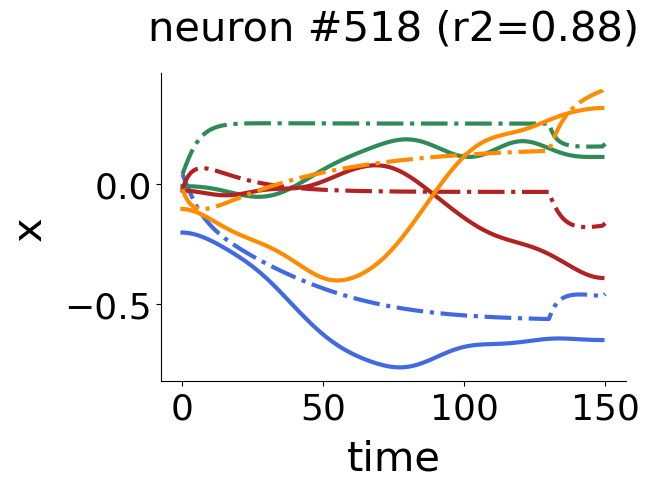

0.876440890495806


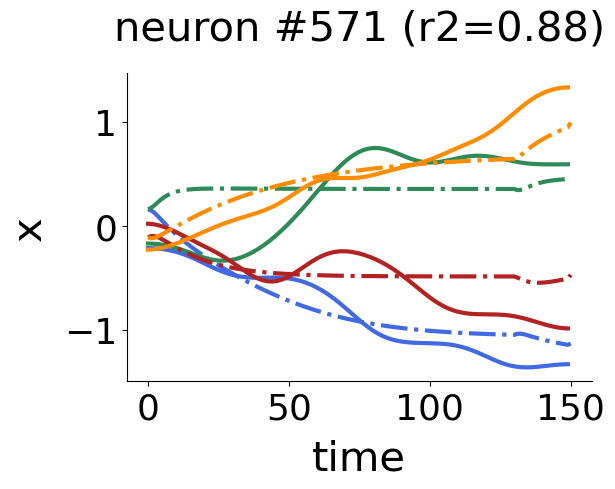

0.8748688494075638


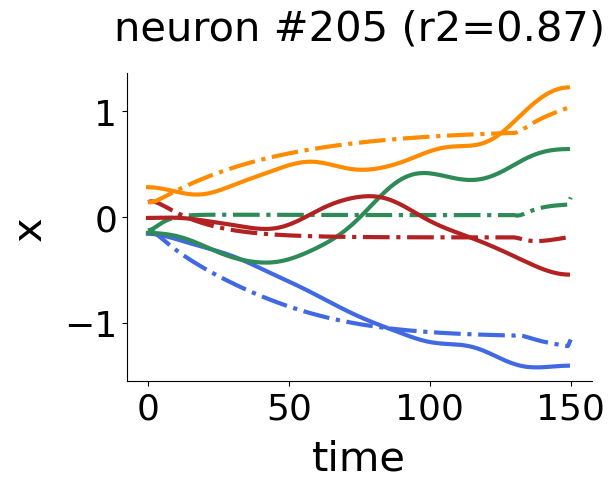

0.8743562240428385


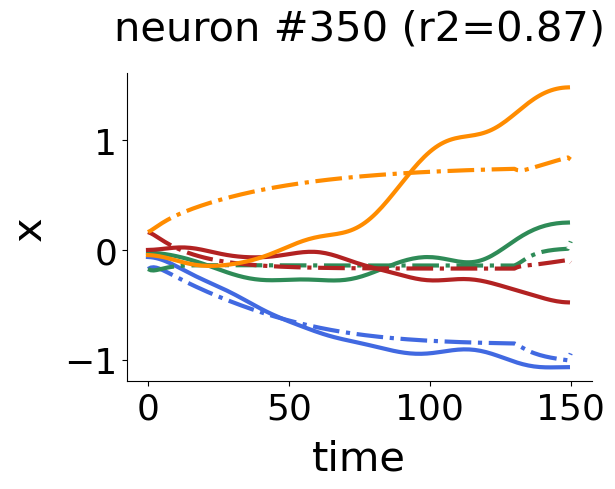

0.8732985462745209


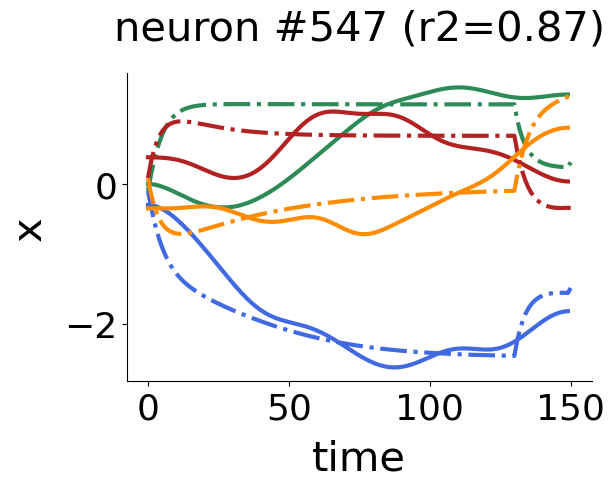

In [59]:
for i in np.argsort(r2s_all)[::-1][:10]:
    print(r2s_all[i])
    for c, k in enumerate(conditions_sample):
        pl, = plt.plot(X_cent[k, :, i].squeeze(), c=colors[c], lw=3)
        plt.plot(traj[k, mante.ctx_only_pre_duration_discrete:, i].squeeze(), ls='-.', c=pl.get_color(), lw=3)
    plt.title(f'neuron #{neurons_map_orig[i]} (r2={r2s_all[i]:.2f})')
    plt.xlabel('time')
    plt.ylabel('x')
    plt.savefig(f'../figures/neurips/monkeyF_neuron{neurons_map_orig[i]}.pdf', bbox_inches='tight')
    plt.show()

0.3477545672027508


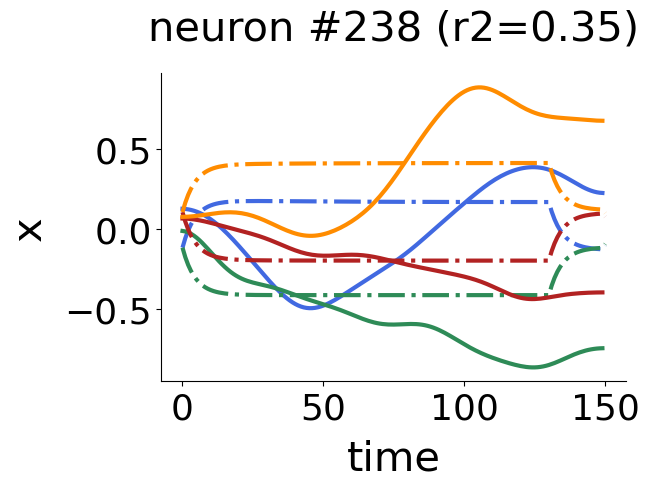

0.6605880971064827


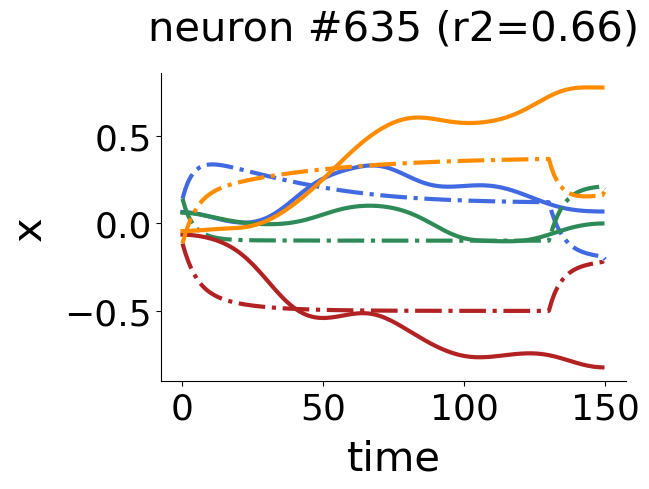

0.8732985462745209


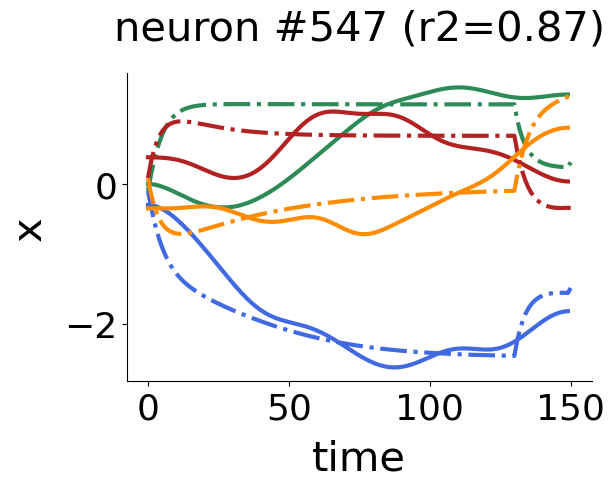

0.31918995362547264


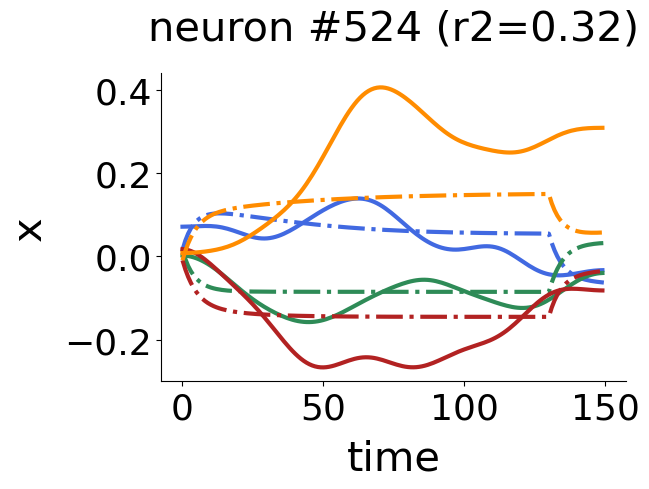

In [60]:
rdm_neurons = np.random.choice(np.arange(size), 4, replace=False)
for i in rdm_neurons:
    print(r2s_all[i])
    for c, k in enumerate(conditions_sample):
        pl, = plt.plot(X_cent[k, :, i].squeeze(), c=colors[c], lw=3)
        plt.plot(traj[k, mante.ctx_only_pre_duration_discrete:, i].squeeze(), ls='-.', c=pl.get_color(), lw=3)
    plt.title(f'neuron #{neurons_map_orig[i]} (r2={r2s_all[i]:.2f})')
    plt.xlabel('time')
    plt.ylabel('x')
    plt.savefig(f'../figures/neurips/si_monkeyF_neuron{neurons_map_orig[i]}.pdf', bbox_inches='tight')
    plt.show()

## Connectivity

In [61]:
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()
wi_ctx1 = net.wi[2].detach().numpy()
wi_ctx2 = net.wi[3].detach().numpy()
m = net.m.detach().squeeze().numpy()
n = net.n.detach().squeeze().numpy()

In [62]:
_, wi1_orth, wi2_orth = helpers.gram_schmidt([m, wi1, wi2])

In [63]:
vecs = [wi1, wi2, wi_ctx1, wi_ctx2, n, m]
z, model = clustering.gmm_fit(vecs, 2, algo='bayes', random_state=2022)

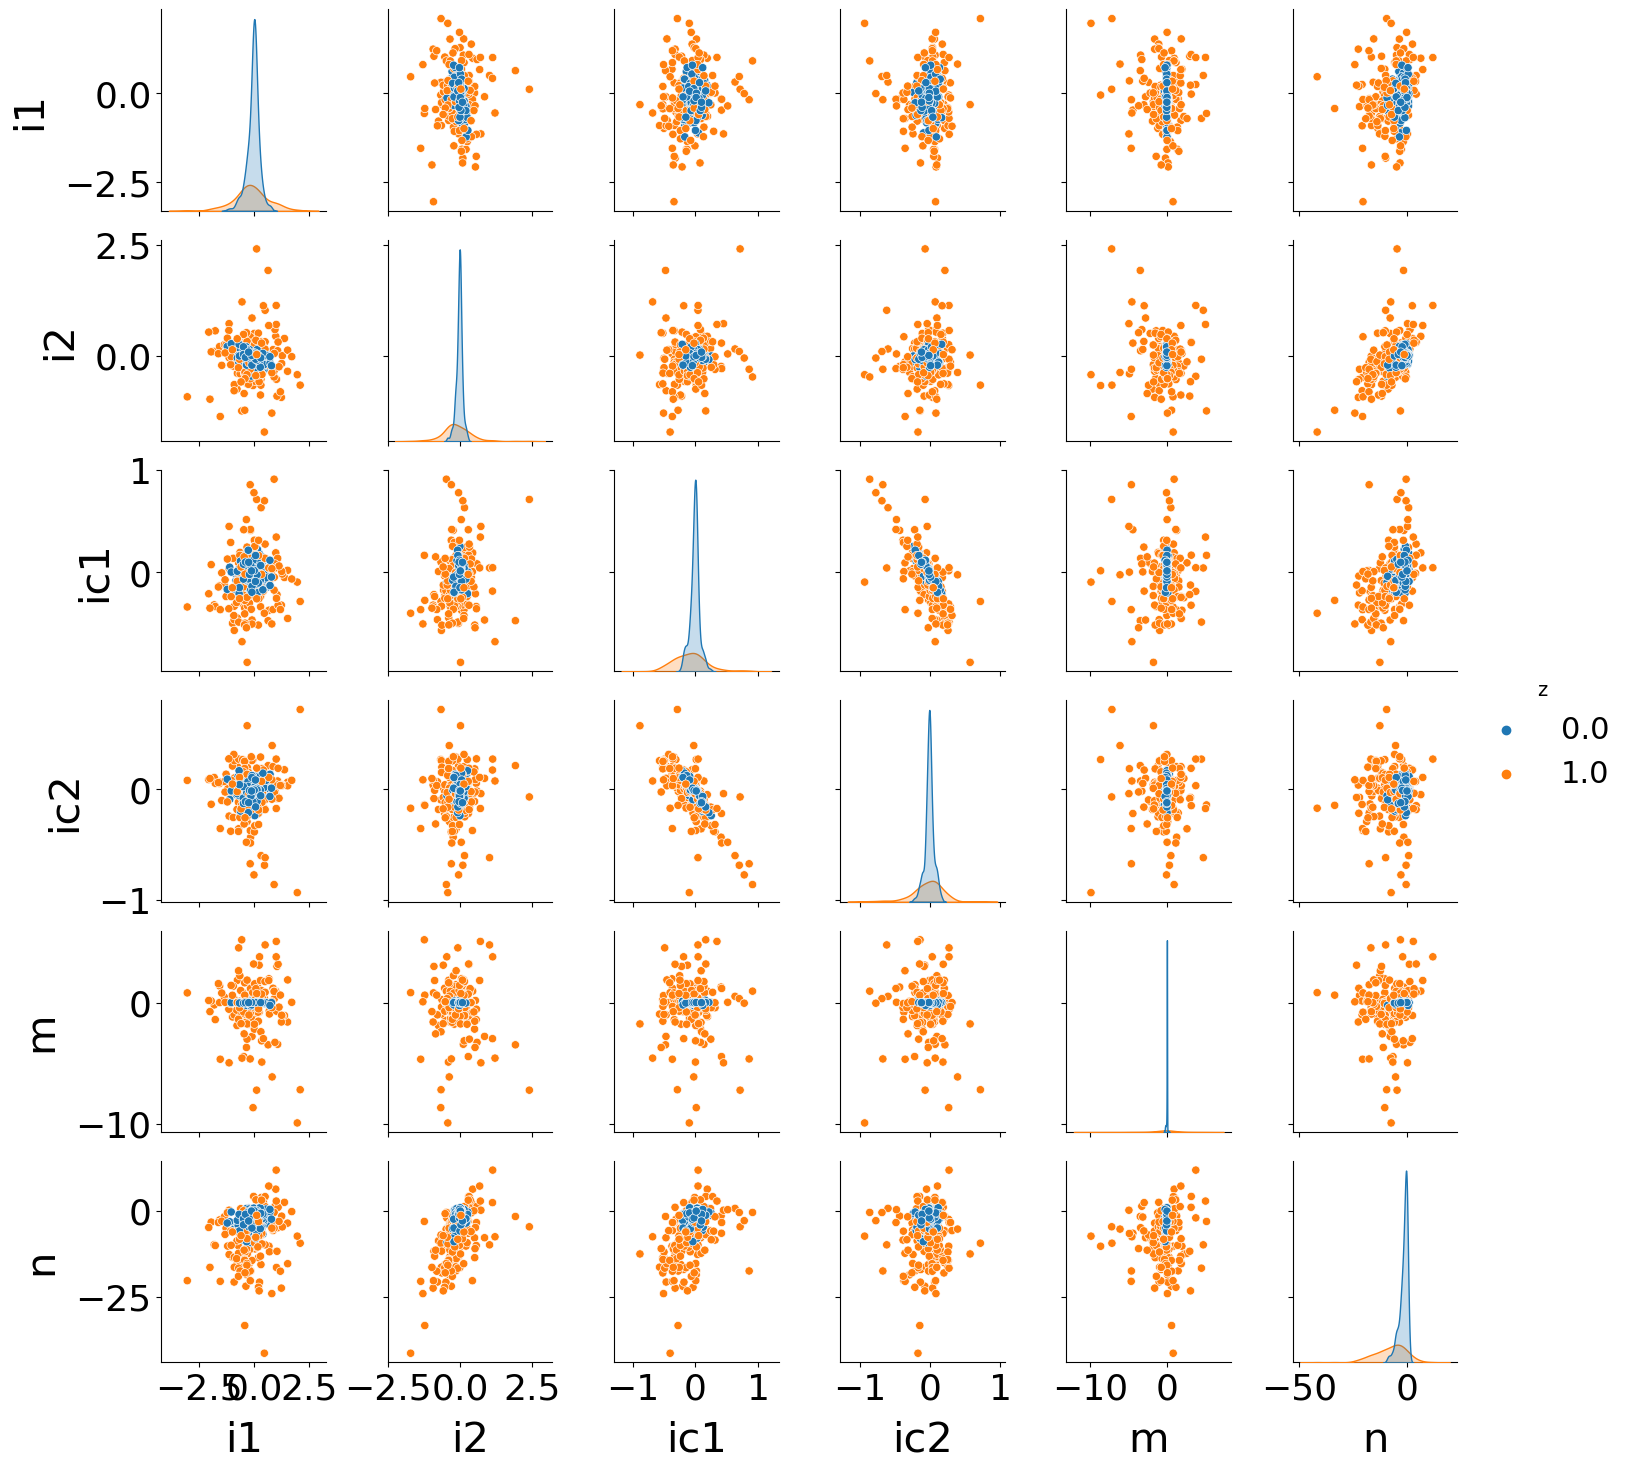

In [64]:
data_plot = pd.DataFrame(np.stack(vecs + [z]).T, columns = ['i1', 'i2', 'ic1', 'ic2', 'm', 'n', 'z'])
sns.pairplot(data_plot, hue='z')
plt.savefig('../figures/neurips/distr_monkeyA.pdf', bbox_inches='tight')

In [65]:
kurtosis(np.array(vecs).T, fisher=True)

array([ 4.912993 , 14.419834 ,  6.3973494, 10.447903 , 19.900002 ,
        7.552125 ], dtype=float32)

/Users/avalente/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/avalente/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


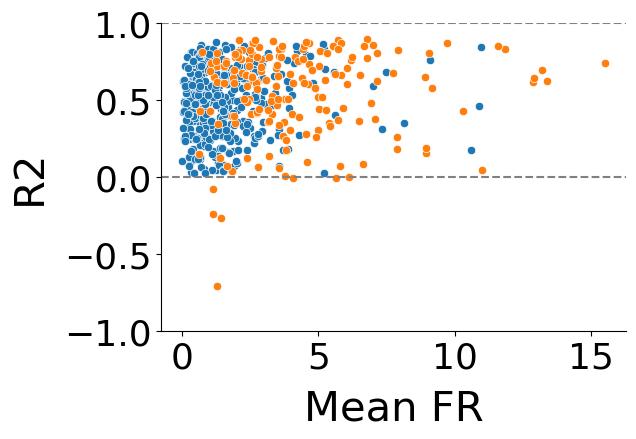

In [67]:
# Are poorly fitted neurons irrelevant ?
# r2s = np.array(stats.r2_idneurons(X_cent, traj, return_all=True))
sns.scatterplot(X_mean[z==0], r2s_all[z==0], color='tab:blue')
sns.scatterplot(X_mean[z==1], r2s_all[z==1], color='tab:orange')
plt.ylim(-1, 1)
plt.axhline(0, c='gray', ls='--')
plt.axhline(1, c='gray', ls='--')
plt.xlabel('Mean FR')
plt.ylabel('R2')
plt.savefig('../figures/neurips/distr_r2mA.pdf', bbox_inches='tight')

In [68]:
len(set(idx_bad).intersection(set(np.where(z==1)[0])))

16

## Projections

In [69]:
def plot_projection(X1, X2, conditions, ax1, ax2, colors, xlabel=None, ylabel=None):
    for c, cond in enumerate(conditions):
        plt.plot(X1[cond].mean(axis=0) @ ax1,
                 X1[cond].mean(axis=0) @ ax2, c=colors[c], lw=3)
        plt.scatter(X1[cond].mean(axis=0)[0] @ ax1,
                 X1[cond].mean(axis=0)[0] @ ax2,
                 marker='o', color=colors[c])
        plt.plot(X2[cond].mean(axis=0) @ ax1,
                 X2[cond].mean(axis=0) @ ax2,
                 c=colors[c], ls='dotted', lw=3)
        plt.scatter(X2[cond].mean(axis=0)[0] @ ax1,
                 X2[cond].mean(axis=0)[0] @ ax2,
                 marker='o', color=colors[c])
        plt.scatter(X2[cond].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax1,
                    X2[cond].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax2,
                    color=colors[c], marker='^', s=100)
        if xlabel is not None: plt.xlabel(xlabel)
        if ylabel is not None: plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])

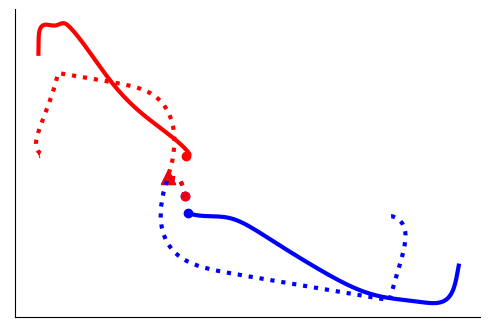

In [70]:
cmap = matplotlib.cm.get_cmap('bwr')
colors = [cmap(0), cmap(256)]
conditions = [((direction == 0) & (context == 1)),
              ((direction == 5) & (context == 1))]
plot_projection(X_cent, traj, conditions, beta_choice, beta_motion, colors)

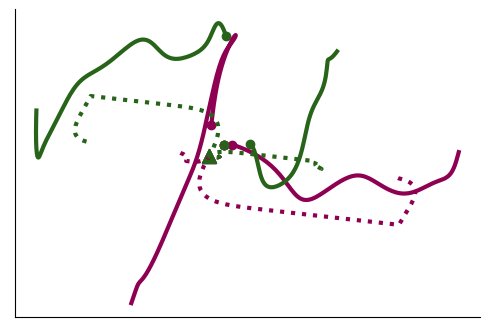

In [71]:
cmap = matplotlib.cm.get_cmap('PiYG')
colors = [cmap(0)] * 2 + [cmap(256)] * 2
conditions = [((color == i) & (context == 1) & (choice == j)) for i in (0, 5) for j in (-1, 1)]
plot_projection(X_cent, traj, conditions, beta_choice, beta_color, colors)

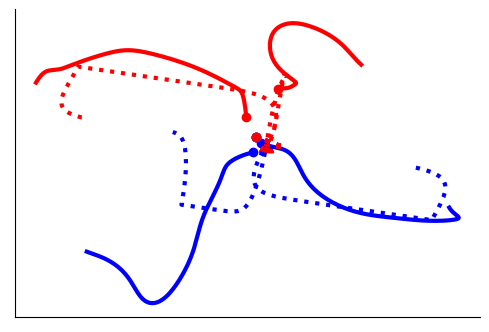

In [72]:
cmap = matplotlib.cm.get_cmap('bwr')
colors = [cmap(0)] * 2 + [cmap(256)] * 2
conditions = [(direction == i) & (context == -1) & (choice == j) for i in (0, 5) for j in (-1, 1)]
plot_projection(X_cent, traj, conditions, beta_choice, beta_motion, colors)

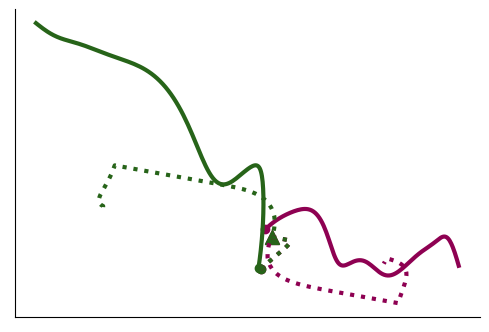

In [73]:
cmap = matplotlib.cm.get_cmap('PiYG')
colors = [cmap(0), cmap(256)]
conditions = [((color == 0) & (context == -1)), ((color == 5) & (context == -1))]
plot_projection(X_cent, traj, conditions, beta_choice, beta_color, colors)

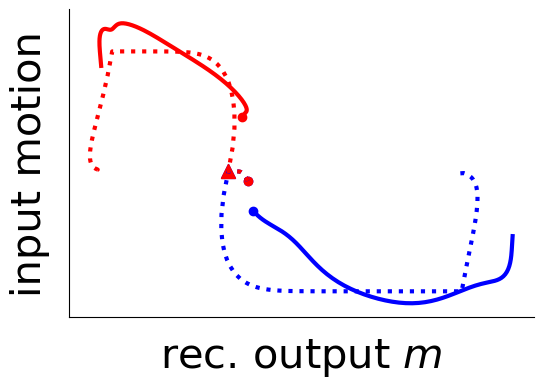

In [74]:
cmap = matplotlib.cm.get_cmap('bwr')
colors = [cmap(0), cmap(256)]
conditions = [((direction == 0) & (context == 1)),
              ((direction == 5) & (context == 1))]
plot_projection(X_cent, traj, conditions, m, wi1_orth, colors, 'rec. output $m$', 'input motion')
plt.savefig('../figures/neurips/monkeyF_p1.pdf', bbox_inches='tight')

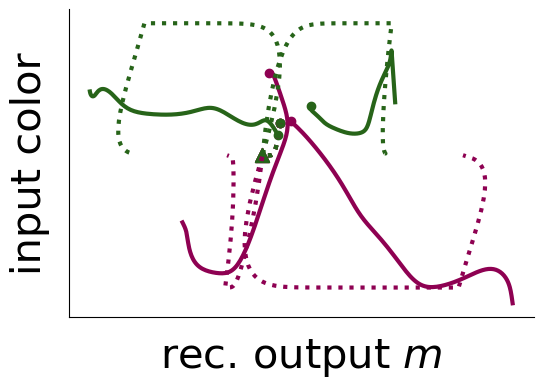

In [75]:
cmap = matplotlib.cm.get_cmap('PiYG')
colors = [cmap(0)] * 2 + [cmap(256)] * 2
conditions = [((color == i) & (context == 1) & (choice == j)) for i in (0, 5) for j in (-1, 1)]
plot_projection(X_cent, traj, conditions, m, wi2_orth, colors, 'rec. output $m$', 'input color')
plt.savefig('../figures/neurips/monkeyF_p2.pdf', bbox_inches='tight')

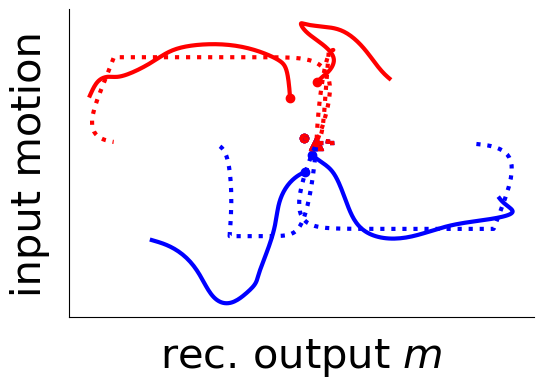

In [76]:
cmap = matplotlib.cm.get_cmap('bwr')
colors = [cmap(0)] * 2 + [cmap(256)] * 2
conditions = [(direction == i) & (context == -1) & (choice == j) for i in (0, 5) for j in (-1, 1)]
plot_projection(X_cent, traj, conditions, m, wi1_orth, colors, 'rec. output $m$', 'input motion')
plt.savefig('../figures/neurips/monkeyF_p3.pdf', bbox_inches='tight')

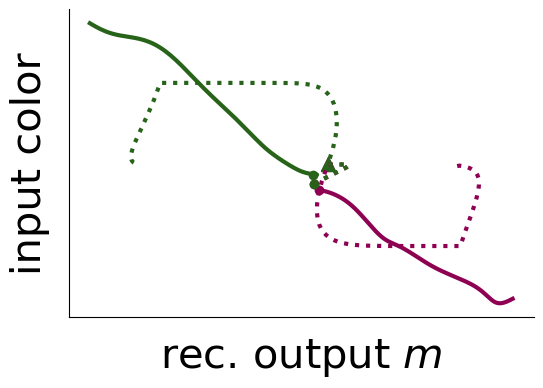

In [77]:
cmap = matplotlib.cm.get_cmap('PiYG')
colors = [cmap(0), cmap(256)]
conditions = [((color == 0) & (context == -1)), ((color == 5) & (context == -1))]
plot_projection(X_cent, traj, conditions, m, wi2_orth, colors, 'rec. output $m$', 'input color')
plt.savefig('../figures/neurips/monkeyF_p4.pdf', bbox_inches='tight')

## Inactivation

These confirm that the whole computation is supported by the orange neurons (z==1)

In [78]:
# Lets' inactivate the population 0, the one that should be doing nothing
net_tmp = net_behav.clone()
with torch.no_grad():
    net_tmp.wi[:, z==0] = 0
    net_tmp.m[z==0] = 0
    net_tmp.n[z==0] = 0
loss, acc = mante.test_mante(net_tmp, inputs, targets_task, mask_task)
print(acc)
# train(net_tmp, inputs, targets_task, mask_task, 30, lr=5e-1, keep_best=True)  # training the readout only

0.9722222089767456


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

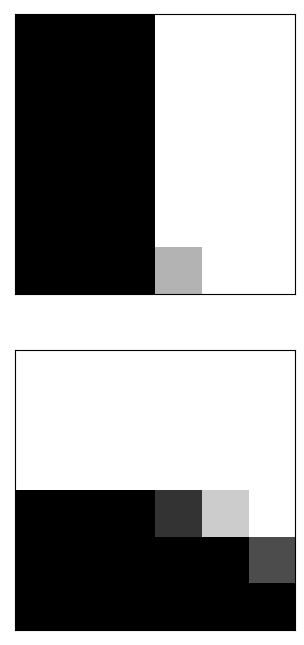

In [79]:
mante.psychometric_matrices(net_tmp, coherences=coherences)

In [80]:
# Lets' inactivate the population 0, the one that should be doing nothing
net_tmp = net_behav.clone()
with torch.no_grad():
    net_tmp.wi[:, z==1] = 0
    net_tmp.m[z==1] = 0
    net_tmp.n[z==1] = 0
loss, acc = mante.test_mante(net_tmp, inputs, targets_task, mask_task)
print(acc)
# train(net_tmp, inputs, targets_task, mask_task, 30, lr=5e-1, keep_best=True)  # training the readout only

0.5


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

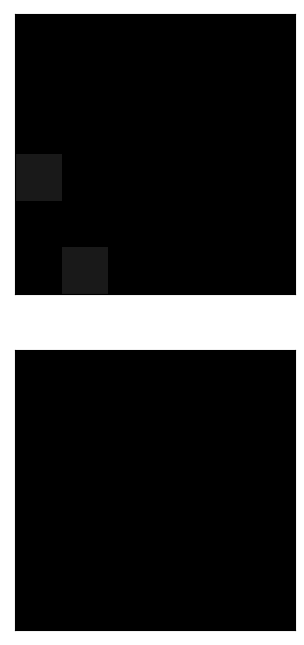

In [81]:
mante.psychometric_matrices(net_tmp, coherences=coherences)